In [10]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))

In [28]:
import utils
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True,
 collate_fn=utils.collate_fn)
images,targets = next(iter(data_loader))
images = list(image for image in images)
img = images[0]

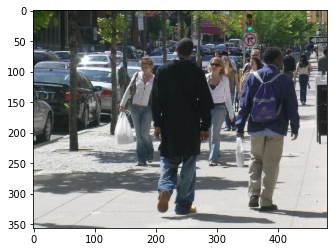

In [29]:
import torchvision
trans_img = torchvision.transforms.ToPILImage()
plt.imshow(trans_img(img))
plt.show()

In [37]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [39]:
from engine import train_one_epoch, evaluate



def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")


In [40]:
if __name__ == "__main__":
    main()

/Users/erfan/opt/anaconda3/envs/CS231n_env/lib/python3.10/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0]  [ 0/60]  eta: 0:18:22  lr: 0.000090  loss: 3.7715 (3.7715)  loss_classifier: 1.0997 (1.0997)  loss_box_reg: 0.2811 (0.2811)  loss_mask: 2.3678 (2.3678)  loss_objectness: 0.0174 (0.0174)  loss_rpn_box_reg: 0.0056 (0.0056)  time: 18.3683  data: 0.0396
Epoch: [0]  [10/60]  eta: 0:18:51  lr: 0.000936  loss: 1.8705 (2.0634)  loss_classifier: 0.5421 (0.6121)  loss_box_reg: 0.2225 (0.2777)  loss_mask: 0.7448 (1.1465)  loss_objectness: 0.0217 (0.0222)  loss_rpn_box_reg: 0.0032 (0.0050)  time: 22.6220  data: 0.0864
Epoch: [0]  [20/60]  eta: 0:15:58  lr: 0.001783  loss: 0.9733 (1.4315)  loss_classifier: 0.2712 (0.4202)  loss_box_reg: 0.2187 (0.2696)  loss_mask: 0.3865 (0.7162)  loss_objectness: 0.0181 (0.0191)  loss_rpn_box_reg: 0.0053 (0.0064)  time: 24.2386  data: 0.0918
Epoch: [0]  [30/60]  eta: 0:11:35  lr: 0.002629  loss: 0.5019 (1.1341)  loss_classifier: 0.1134 (0.3103)  loss_box_reg: 0.2187 (0.2524)  loss_mask: 0.2059 (0.5504)  loss_objectness: 0.0056 (0.0150)  loss_rpn_box_re

Epoch: [2]  [ 0/60]  eta: 0:22:34  lr: 0.005000  loss: 0.1417 (0.1417)  loss_classifier: 0.0127 (0.0127)  loss_box_reg: 0.0262 (0.0262)  loss_mask: 0.1024 (0.1024)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 22.5692  data: 0.0219
Epoch: [2]  [10/60]  eta: 0:19:17  lr: 0.005000  loss: 0.1906 (0.2132)  loss_classifier: 0.0228 (0.0260)  loss_box_reg: 0.0565 (0.0635)  loss_mask: 0.1047 (0.1189)  loss_objectness: 0.0006 (0.0017)  loss_rpn_box_reg: 0.0028 (0.0031)  time: 23.1443  data: 0.0730


KeyboardInterrupt: 